In [1]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 4.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.9 MB/s eta 0:00:00


1. Δημιουργία κλάσης προ-προεπεξεργασίας χρονοσειρών συνόλου δεδομένων Timematch.
2. Δημιουργία κλάσης τυχαίας δειγματοληψίας εικονοστοιχείων από κάθε χρονοσειρά.

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchmetrics
from torchmetrics.classification import (MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix)
from sklearn.model_selection import StratifiedKFold
import json
import zarr
import pickle
import os

In [5]:
class TimeMatchPreprocessor:
    """
    Preprocessing Pipeline for the TimeMatch dataset where the following tasks are implemented: 
    1) Filter labels that are assigned to less than 200 plots
    2) Pixelwise normalization
    """
    def __init__(self, plots_root: str, labels_json: str, metadata_path: str, 
                 min_count: int = 200):
        """
        Args:
          plots_root: path to zarr dirs in the range 1...5000 which contain binary files
          labels_json: JSON file with mapping plot_id -> label
          metadata_path: path to the .pkl file where the acquisiton dates for the timeseries are stored
          min_counts: minimum number of times a class must be present in the dataset in order to be considered
        """
        self.plots_root = plots_root
        self.labels_json = labels_json
        self.min_count = min_count
        self.metadata_path = metadata_path

        # To be determined during preprocessing
        self.labels = {}
        self.filtered_labels = {}
        self.label2idx = {}
        self.idx2label = {}
        self.plot_ids = []

    def load_labels(self):
        """Load the plot labels from the JSON file and count the frequencies"""
        with open(self.labels_json, 'r') as f:
            data = json.load(f)
          
        # Count the frequency of labels assigned to the plots
        counts = {}
        for pid, lbl in data.items():
            counts[lbl] = counts.get(lbl, 0) + 1
          
        # Filter the labels that are assigned less than 200 times to the plots
        kept = {lbl for lbl, c in counts.items() if c >= self.min_count}
      
        # Build new mapping
        self.filtered_labels = {int(pid): lbl for pid, lbl in data.items() if lbl in kept}
        self.plot_ids = list(self.filtered_labels.keys())
      
        # Reindex remaining classes
        sorted_labels = sorted(kept)
        self.label2idx = {lbl: idx for idx, lbl in enumerate(sorted_labels)}
        self.idx2label = {idx: lbl for lbl, idx in self.label2idx.items()}

    def load_acc_dates(self):
        """Load the acquisition dates of the plots timeseries"""
        with open(self.metadata_path, 'rb') as f:
            metadata = pickle.load(f)

        # Extract the acquisition dates
        dates = metadata['dates']
        
        # Convert date format from YYYYMMDD to DOY
        dates_doy = [int(str(date)[4:6]) * 30 + int(str(date)[6:8]) for date in dates]

        return dates_doy

    def normalize(self, arr: np.ndarray) -> np.ndarray:
        """Normalize pixel values to [0,1] range"""
        return arr.astype(np.float32) / 65535.0

    def load_plot_array(self, plot_id: int) -> np.ndarray:
        """"Load the zarr array for a plot: returns numpy array of shape (T, H, W, C)"""
        plot_dir = self.plots_root+'/'+str(plot_id)+'.zarr'

        z = zarr.open_array(plot_dir, mode='r', zarr_format=2)
        arr = np.array(z)  # (T, C, H) --> (temp_channels, spectral_channels, num_pixels)
        return arr

    def process_all(self):
        """Process all plots and return a tuple of the type (id, arrays, labels)"""
        dataset = []
        inv_lbls = []
        dates = self.load_acc_dates()
        for pid in self.plot_ids:
            arr = self.load_plot_array(pid)
            arr = self.normalize(arr)
            lbl = self.label2idx[self.filtered_labels[pid]]
            inv_lbl = self.idx2label[lbl]
            dataset.append((pid, arr, lbl))
            inv_lbls.append(inv_lbl)
        return dataset, inv_lbls, dates

    def run(self):
        """Run the whole preprocessing pipeline: load_labels, process_all"""
        self.load_labels()
        processed = self.process_all()
        return processed

class PixelSamplerDataset(Dataset):
    def __init__(self, images, labels, num_pixels=32):
        """
        Args:
            images: torch.Tensor or np.ndarray, shape (N, T, C, N_pixels), where N is the length of the timeseries
            labels: list/array with N labels
            num_pixels: number of pixels
        """
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.num_pixels = num_pixels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx] # shape (T, C, N_pixels)
        label = self.labels[idx]

        # Spatial sampling
        T, C, N = img.shape
        idxs = torch.randperm(N)[: self.num_pixels]
        sampled = img[:, :, idxs] # shape (T, C, S), where S are the randomly sampleδ pixels

        # Permute to (T, S, C) shape for the input of the 1st MLP of PixelSetEncoder
        pixels = torch.tensor(sampled, dtype=torch.float32).permute(0, 2, 1)

        return pixels, torch.tensor(label, dtype=torch.long)

1. Αρχιτεκτονική 1ου MLP εισόδου χρονοσειρών στον pixel set encoder
2. Αρχιτεκτονική 2ου MLP εισόδου pooled διανύσματος χαρακτηριστικών από την έξοδο του 1ου MLP στον pixel set encoder

In [ ]:
class MLP_1(nn.Module):
    """
    1st MLP of the Pixel-Set Encoder:
    Takes as input tensors x with shape (B, T, S, C) and returns tensors with (B, T, S, 32) shape.
    After each MLP layer, batch normalization is applied to the features tensor.
    """
    def __init__(self, input_dim=10, hidden_dim=16, output_dim=32):
        """
        Args:
            1) input_dim=C (C: num_channels)
            2) hidden_dim=16
            3) output_dim=32
        
        """
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass through the MLP layer.
        Args:
            x (torch.Tensor): Input tensor of shape (B, T, S, C)

        Returns:
            torch.Tensor: Output tensor of shape (B, T, S, output_dim)
        """
        B, T, S, C = x.shape

        # Flatten batch, & pixels → (B*T, S, C) → (B*T*S, C)
        x = x.view(B * T, S, C)
        x = x.view(B * T * S, C)

        x = self.linear1(x)     # (B*T*S, hidden_dim)
        x = self.bn1(x)         # Batch normalization to features=hidden_dim
        x = self.relu1(x)

        x = self.linear2(x)     # (B*T*S, output_dim)
        x = self.bn2(x)
        x = self.relu2(x)

        # Reshape again back to (B*T, S, output_dim)
        x = x.view(B * T, S, -1)
        return x
	
class MLP_2(nn.Module):
    """
    The second MLP layer of the pixel set encoder which consists of:
    - Input: a duplet of pooled (average and std concat) pixel features from MLP_1
     --> 2*32=64 neurons
    - Output: 128 neurons, BatchNorm, ReLU activation
    """
    def __init__(self, input_dim=36, output_dim=64):
        """Initialize the 2nd MLP layer of the Pixel Set Encoder.
        
        Args:
        	input_dim (int): The number of input features (default: 32+4 when accounting for geometrical characteristics).
        	output_dim (int): The number of neurons in the hidden layer (default: 64).
        """
        super(MLP_2, self).__init__()
        
        # Define the network architecture
        self.mlp2 = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        """Forward pass through the MLP layer after concatentation of 
        mean and standard deviation pooling of sampled pixels.
        
        Args:
        	x (torch.Tensor): Input tensor of shape (2*32, input_dim).
        
        Returns:
        	torch.Tensor: Output tensor of shape (2*32, output_dim).
        """
        
        return self.mlp2(x)

1. Κλάση υλοποίησης positional encoding βάσεις των ημερομηνιών απόκτησης δεδομένων
2. Αρχιτεκτονική temporal attention encoder
3. Αρχιτεκτονική ενός MLP το οποίο λειτουργεί σαν decoder για την ταξινόμηση διανύσματος εξόδου από τον temporal attention encoder στις τελικές κατηγορίες ταξινόμησης

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implements positional encoding to the input of the temporal attention encoder.
    """
    def __init__(self, d_model: int, ts_dates: list, 
                 drop_rate: float = 0.15):
        """
        Initialize positional encoding

        Args:
            d_model (int): Dimension of the model embeddings
            ts_dates (list): a list with the acquisition dates of the plots timeseries in DOY format
            drop_rate (float): Dropout rate for positional encoding
        """
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.ts_dates = ts_dates
        self.drop_rate = drop_rate

        # Intialize dropout layer and classification token for positional encoding
        self.dropout = nn.Dropout(p=self.drop_rate)
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_model))

        # Create positional encoding matrix
        position = torch.tensor(self.ts_dates, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-np.log(1000.0) / self.d_model))

        # Initialize positional encoding buffer
        L = len(self.ts_dates) # length of the temporal sequence
        pe = torch.zeros(1, L, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[0, :, 1::2] = torch.cos(position * div_term)  # Odd dimensions

        # Register as buffer (won't be updated during backprop)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input tensor     
        Args:
            x: Input tensor of shape [batch_size, seq_len, embedding_dim]       
        Returns:
            Tensor with positional encoding added
        """
        if x.dim() <3:
            X = x.unsqueeze(0) # add batch dimension if not present
        B, _, D = X.shape

        # Positional encoding
        pe = self.pe[:, :len(self.ts_dates), :]  # (B, L, d_model))
        
        # Classification token
        cls = self.cls_token.expand(B, 1, D)    # (B,1,d_model)
        x1 = torch.cat([cls, X], dim=1)
        x2 = torch.cat([cls, X + pe], dim=1)

        return self.dropout(x1), self.dropout(x2)

class TemporalAttentionEncoder(nn.Module):
    def __init__(self, d_e: int, d_k: int, H: int,
                 mlp_ldims: list):
        """
        Args:
            d_e (int): Dimension of the input embedding
            d_k (int): Dimension of the shared keys and queries dimension
            H (int): Number of heads
            mlp_ldims (list): Ordered list with the dimensions of the MLP3 hidden and output layers
        """
        super().__init__()
        self.d_e = d_e
        self.d_k = d_k
        self.H = H

        # Fully connected layers for key, query and value projections
        self.fc1_k = nn.Linear(d_e, H * d_k)
        self.fc1_q = nn.Linear(d_e, H * d_k)
        self.fc1_v = nn.Linear(d_e, H * d_k)
        
        # Second fully connected layer for the estimation of the master query
        self.fc2 = nn.Linear(H * d_k, H * d_k)

        # Scaled dot product attention instance
        self.attention = F.scaled_dot_product_attention()

        # MLP3 architecture
        self.mlp3 = nn.Sequential(
            nn.Linear(d_e, mlp_ldims[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(mlp_ldims[0], mlp_ldims[1]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(mlp_ldims[1], mlp_ldims[2]))

        # Layer normalizations after attention and MLP3
        self.ln1 = nn.LayerNorm(self.d_e)
        self.ln2 = nn.LayerNorm(mlp_ldims[-1])

    def forward(self, e: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the temporal attention encoder.

        Args:
            e (torch.Tensor): Input tensor of shape [B, T, d_e]
            p (torch.Tensor): Positional encoding tensor of shape [B, T, d_e]

        Returns:
            torch.Tensor: Output tensor of shape [B, mlp_ldims[-1]]
        """
        B, T, _ = e.shape

        # Position-aware embedding
        pe = e + p                 # (B,T,d_e)

        # Linear projections
        Q = self.fc1_q(pe)         # (B,T,H*d_k)
        K = self.fc1_k(pe)
        V = self.fc1_v(pe)

        # helper function for splitting heads to (H*B, T, d_k) dimensions
        def split_heads(x):
            x = x.view(B, T, self.H, self.d_k)        # (B,T,H,d_k)
            x = x.permute(2, 0, 1, 3).contiguous()       # (H,B,T,d_k)
            return x.view(self.H*B, T, self.d_k)      # (H*B,T,d_k)

        # Apply the function to the query and keys projection
        k = split_heads(K)
        v = split_heads(V)

        # Master query (mean in the temporal dimension --> FC2 --> split heads)
        Q0 = Q.view(B, T, self.H, self.d_k)           # (B,T,H,d_k)
        q_mean = Q0.mean(dim=1)                       # (B,H,d_k)
        q_hat  = self.fc2(q_mean.view(B, self.H*self.d_k))  # (B,H*d_k)
        q_hat  = q_hat.view(B, self.H, self.d_k)      # (B,H,d_k)
        # split to (H*B,1,d_k)
        q = (
            q_hat.permute(1,0,2)                      # (H,B,d_k)
                 .contiguous()
                 .view(self.H*B, 1, self.d_k)         # (H*B,1,d_k)
        )

        # Scaled dot-product attention
        out = F.scaled_dot_product_attention(q, k, v,   
            attn_mask=None, dropout_p=0.1, is_causal=False)                                            # (H*B,1,d_k)

        # Concatenate heads -> (B,H*d_k)
        out = out.view(self.H, B, self.d_k)                      # (H, B, d_k)
        out = out.permute(1, 0, 2).contiguous().view(B, self.H * self.d_k)
        
        pe_mean = pe.mean(dim=1)                    # (B, d_e)
        out = self.ln1(pe_mean + out)
        
        # MLP3
        y = self.mlp3(out)                          # (B, mlp_ldims[-1])
        y = self.ln2(y + out)  
        
        return y                               # (B, mlp_ldims[-1])


class Decoder(nn.Module):
    """
    Implements a decoder for the temporal attention encoder output.
    The decoder consists of a MLP with two hidden layers and an output layer.
    The dimensions of the hidden layers are hyperparameters and the output layer dimension
    should be equal to the number of classes present in the dataset after preprocessing.
    """
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int):
        """
        Args:
            input_dim (int): Dimension of the input embedding
            hidden_dims (list): List of dimensions for the 2 hidden layers
            output_dim (int): Dimension of the output layer which should be equal
            to the number of classes in the dataset
        """
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims[1], output_dim),
            nn.ReLU(inplace=True))
        
    def forward(self, x):
        """
        Forward pass through the decoder
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, input_dim]
        Returns:
            torch.Tensor: Output tensor of shape [batch_size, output_dim], where output_dim is the number of classes"""
        return self.model(x)

Κλάση με τις μεθόδους εκπαίδευσης και επικύρωσης ανά εποχή

In [32]:
class ModelsTrainer:
    """
    Trainer class for training the encoder based model for crop classification

    Features:
    - Training and validation loops
    - Metrics tracking
    - Visualization utilities
    - Model checkpointing
    """

    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        learning_rate=1e-3,
        num_epochs=50,
        device="cuda",
        checkpoint_dir="/kaggle/working/checkpoints",
        num_classes=10,
        early_stop_patience=10
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.early_stop_patience = early_stop_patience
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                         self.optimizer,
                         mode='min',
                         factor=0.5,
                         patience=3)
        self.criterion = nn.CrossEntropyLoss()

        # Torchmetrics initialization
        self.metric_accuracy = MulticlassAccuracy(num_classes=self.num_classes, average='micro').to(device)
        self.metric_precision_micro = MulticlassPrecision(num_classes=self.num_classes, average='micro').to(device)
        self.metric_precision_weighted = MulticlassPrecision(num_classes=self.num_classes, average='weighted').to(device)
        self.metric_recall_micro = MulticlassRecall(num_classes=self.num_classes, average='micro').to(device)
        self.metric_recall_weighted = MulticlassRecall(num_classes=self.num_classes, average='weighted').to(device)
        self.metric_f1_micro = MulticlassF1Score(num_classes=self.num_classes, average='micro').to(device)
        self.metric_f1_weighted = MulticlassF1Score(num_classes=self.num_classes, average='weighted').to(device)
        self.metric_cm = MulticlassConfusionMatrix(num_classes=self.num_classes).to(device)

        # Lists for metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        self.train_wf1 = []
        self.val_wf1 = []
        self.train_mf1 = []
        self.val_mf1 = []

        self.train_wrec = []
        self.val_wrec = []
        self.train_mrec = []
        self.val_mrec = []

        self.train_wprec = []
        self.val_wprec = []
        self.train_mprec = []
        self.val_mprec = []

        # Checkpointing
        self.checkpoint_dir = checkpoint_dir
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.best_val_acc = 0
        self.best_val_loss = float("inf")

    def evaluate_batch(self, output, labels):
        # output: logits (B, num_classes), labels: (B,)
        # Extract predictions
        if output.ndim > 1:
            preds = output.argmax(dim=1)
        else:
            preds = output
            
        # Ensure that the predictions and the labels are in the same device with the metrics
        preds = preds.to(self.device)
        labels = labels.to(self.device)
    
        # Metrics instances
        acc = self.metric_accuracy(preds, labels).cpu().item()
        prec_micro = self.metric_precision_micro(preds, labels).cpu().item()
        prec_weighted = self.metric_precision_weighted(preds, labels).cpu().item()
        rec_micro = self.metric_recall_micro(preds, labels).cpu().item()
        rec_weighted = self.metric_recall_weighted(preds, labels).cpu().item()
        f1_micro = self.metric_f1_micro(preds, labels).cpu().item()
        f1_weighted = self.metric_f1_weighted(preds, labels).cpu().item()
        cm = self.metric_cm(preds, labels).cpu().numpy()
    
        # Reset state in order to not accumulate consecutive batches
        self.metric_accuracy.reset()
        self.metric_precision_micro.reset()
        self.metric_precision_weighted.reset()
        self.metric_recall_micro.reset()
        self.metric_recall_weighted.reset()
        self.metric_f1_micro.reset()
        self.metric_f1_weighted.reset()
        self.metric_cm.reset()
    
        return {
            "acc": acc,
            "prec_micro": prec_micro,
            "prec_weighted": prec_weighted,
            "rec_micro": rec_micro,
            "rec_weighted": rec_weighted,
            "f1_micro": f1_micro,
            "f1_weighted": f1_weighted,
            "cm": cm,
        }


    def train_epoch(self):
        """Training procedure (logits and loss computation etc.) for one epoch"""
        self.model.train()
        total_loss = 0
        all_labels, all_preds = [], []
    
        for batch_idx, (data, label) in enumerate(self.train_loader):
            data, label = data.to(self.device), label.to(self.device)
            output = self.model(data)
            loss = self.criterion(output, label) # cross entropy function utlized
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.optimizer.zero_grad()

            total_loss += loss.item()
            all_labels.append(label.cpu())
            all_preds.append(output.cpu())

        # Aggregate metrics over all batches
        all_labels = torch.concatenate(all_labels)
        all_preds = torch.concatenate(all_preds, axis=0)
        epoch_metrics = self.evaluate_batch(all_preds, all_labels)

        return total_loss / len(self.train_loader), epoch_metrics


    def validate(self):
        """Run validation"""
        self.model.eval()
        total_loss = 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for batch_idx, (data, label) in enumerate(self.val_loader):
                data = data.to(self.device)

                output = self.model(data)
                loss = self.criterion(output, label.to(self.device))
                total_loss += loss.item()

                all_labels.append(label)
                all_preds.append(output.cpu().numpy())

        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds, axis=0)
        epoch_metrics = self.evaluate_batch(torch.tensor(all_preds), torch.tensor(all_labels))

        return total_loss / len(self.val_loader), epoch_metrics

    def train(self):
        """Main training loop"""
        self.best_cm = None
        
        epoch_pbar = tqdm(
        range(self.num_epochs),
        desc="Training Progress",
        dynamic_ncols=True,
        leave=True
        )
        
        for epoch in epoch_pbar:
            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate()
            train_acc = train_metrics['acc']
            val_acc = val_metrics['acc']

            train_wf1 = train_metrics['f1_weighted']
            val_wf1 = val_metrics['f1_weighted']
            train_mf1 = train_metrics['f1_micro']
            val_mf1 = val_metrics['f1_micro']

            train_wprec = train_metrics['prec_weighted'] 
            val_wprec = val_metrics['prec_weighted']
            train_mprec = train_metrics['prec_micro']
            val_mprec = val_metrics['prec_micro']

            train_wrec = train_metrics['rec_weighted']
            val_wrec = val_metrics['rec_weighted']
            train_mrec = train_metrics['rec_micro']
            val_mrec = val_metrics['rec_micro']
                
            # Append to all the relevant metrics to the lists
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            self.train_wf1.append(train_wf1)
            self.val_wf1.append(val_wf1)
            self.train_mf1.append(train_mf1)
            self.val_mf1.append(val_mf1)

            self.train_wrec.append(train_wrec)
            self.val_wrec.append(val_wrec)
            self.train_mrec.append(train_mrec)
            self.val_mrec.append(val_mrec)

            self.train_wprec.append(train_wprec)
            self.val_wprec.append(val_wprec)
            self.train_mprec.append(train_mprec)
            self.val_mprec.append(val_mprec)

            # Early stopping condition
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_val_loss = val_loss
                self.epochs_since_improvement = 0
                is_best = True
            else:
                self.epochs_since_improvement += 1
                is_best = False
            
            # Check if training on the given fold has yielded the best results
            is_best = False
            if (val_acc > self.best_val_acc) or \
               (val_acc == self.best_val_acc and val_loss < self.best_val_loss):
                is_best = True
                self.best_val_acc  = val_acc
                self.best_val_loss = val_loss
                self.best_cm = val_metrics['cm']
                self.save_checkpoint(epoch + 1, is_best)

            self.scheduler.step(val_loss)
            
            # Update the progress bar for each epoch with the loss and accuracy
            epoch_pbar.set_postfix({
                "train_loss": f"{train_loss:.4f}",
                "train_acc":  f"{train_acc}",
                "val_loss":   f"{val_loss:.4f}",
                "val_acc": f"{val_acc}"})

            # Stop training if no improvement in validation accuracy for a number of epochs
            if self.epochs_since_improvement >= self.early_stop_patience:
                print(f"\nEarly stopping after {self.epochs_since_improvement} epochs without improvement.")
                break

    def save_checkpoint(self, epoch, is_best=False):
        """
        Save model checkpoint

        Args:
            epoch (int): Current epoch number
            is_best (bool): Whether this is the best model so far
        """
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "train_accuracies": self.train_epoch()[1]['acc'],
            "val_accuracies": self.validate()[1]['acc'],
        }

        # Save regular checkpoint
        checkpoint_path = os.path.join(
            self.checkpoint_dir, f"checkpoint_epoch_{epoch}.pt"
        )
        torch.save(checkpoint, checkpoint_path)

        # Save best model separately
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, "best_model.pt")
            torch.save(checkpoint, best_path)

    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint

        Args:
            checkpoint_path (str): Path to checkpoint file
        """
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        # Restore training history
        self.train_losses = checkpoint["train_losses"]
        self.val_losses = checkpoint["val_losses"]
        self.train_accuracies = checkpoint["train_accuracies"]
        self.val_accuracies = checkpoint["val_accuracies"]

        return checkpoint["epoch"]

    def plot_metrics(self):
        """Plot training metrics"""
        # First compute and print the mean and std of all classification metrics on the validation set
        print(f"Mean Acc: {np.mean(self.val_accuracies)}, Std Acc: {np.std(self.val_accuracies)}")
        print(f"Mean Weighted F1: {np.mean(self.val_wf1)}, Std Weighted F1: {np.std(self.val_wf1)}")
        print(f"Mean Micro F1: {np.mean(self.val_mf1)}, Std Micro F1: {np.std(self.val_mf1)}\n")
        print(f"Mean Weighted Precision: {np.mean(self.val_wprec)}, Std Weighted Precision: {np.std(self.val_wprec)}")
        print(f"Mean Micro Precision: {np.mean(self.val_mprec)}, Std Micro Precision: {np.std(self.val_mprec)}\n")
        print(f"Mean Weighted Recall: {np.mean(self.val_wrec)}, Std Weighted Recall: {np.std(self.val_wrec)}")
        print(f"Mean Micro Recall: {np.mean(self.val_mrec)}, Std Micro Recall: {np.std(self.val_mrec)}\n")

        # Plot the confusion matrix of the last tranining epoch of each fold
        cm = self.validate()[1]["cm"]
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label="Train Loss")
        ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label="Train Accuracy")
        ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend()

        fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(15, 5))

        # Plot micro and weighted precision
        ax3.plot(self.val_mprec, label="Micro Precision (Validation)", color='blue')
        ax3.plot(self.val_wprec, label="Weighted Precision (Validation)", color='orange')
        ax3.set_title("Micro and Weighted Precision (Validation and Training Sets)")
        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("Precision")
        ax3.plot(self.train_mprec, label="Micro Precision (Training)", color='green')
        ax3.plot(self.train_wprec, label="Weighted Precision (Training)", color='red')
        ax3.legend()

        # Plot micro and weighted recall
        ax4.plot(self.val_mrec, label="Micro Recall (Validation)", color='purple')
        ax4.plot(self.val_wrec, label="Weighted Recall (Validation)", color='brown')
        ax4.set_title("Micro and Weighted Recall (Validation and Training Sets)")
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Recall")
        ax4.plot(self.train_mrec, label="Micro Recall (Training)", color='pink')
        ax4.plot(self.train_wrec, label="Weighted Recall (Training)", color='gray')
        ax4.legend()

        # Plot micro and weighted F1 score
        ax5.plot(self.val_mf1, label="Micro F1 (Validation)", color='olive')
        ax5.plot(self.val_wf1, label="Weighted F1 (Validation)", color='cyan')
        ax5.set_title("Micro and Weighted F1 (Validation and Training Sets)")
        ax5.set_xlabel("Epoch")
        ax5.set_ylabel("F1 Score")
        ax5.plot(self.train_mf1, label="Micro F1 (Training)", color='red')
        ax5.plot(self.train_wf1, label="Weighted F1 (Training)", color='black')
        ax5.legend()

        plt.tight_layout()
        plt.show()

In [11]:
class FullPipelineModel(nn.Module):
    def __init__(self, ts_dates, input_dim=10, hidden_dim=16, output_dim_1=32, output_dim_2=64, d_model=64, num_classes=10):
        """Initialize the full pipeline model which consists of:
        - Pixel Set Encoder with two MLP layers
        - Temporal Attention Encoder with positional encoding
        Args:
        	ts_dates (list): a list with the acquisition dates of the plots timeseries in DOY format
        	input_dim (int): The number of input features for the first MLP layer (default: 10).
        	hidden_dim (int): The number of neurons in the hidden layer of the first MLP layer (default: 16).
        	output_dim_1 (int): The number of neurons in the output layer of the first MLP layer (default: 32).
        	output_dim_2 (int): The number of neurons in the output layer of the second MLP layer (default: 64).
        	d_model (int): Dimension of the model embeddings for the temporal attention encoder (default: 64).
        	num_classes (int): Number of output classes for classification (default: 10).
        """
        super(FullPipelineModel, self).__init__()
        self.ts_dates = ts_dates
        # Initialize the pixel set encoder
        self.mlp1 = MLP_1(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim_1)
        self.mlp2 = MLP_2(input_dim=int(output_dim_1*2), output_dim=output_dim_2)
        
        # Initialize the temporal attention encoder with positional encoding
        self.pos_enc = PositionalEncoding(d_model=d_model, ts_dates=ts_dates, drop_rate=0.2)
        self.temp_att = TemporalAttentionEncoder(d_e=d_model, d_k=int(d_model / 4), H=4,
        								   fc1_outdim=int(d_model / 4), mlp_ldims=[4 * d_model, d_model, d_model])
        
        # Initial classification layer
        self.classifier = Decoder(input_dim=d_model, hidden_dims=(d_model // 2, d_model // 4),
    						      output_dim=num_classes)
    def forward(self, x):
         # x: (batch_size, doy, num_pixels, input_dim)
         x = self.mlp1(x)  # (batch_size, doy, num_pixels, mlp1_output_dim)
         xm = torch.mean(x, dim=1)  # (batch_size, mlp1_output_dim, num_pixels)
         xs = torch.std(x, dim=1)   # (batch_size, mlp1_output_dim, num_pixels)
         xc = torch.cat([xm, xs], dim=1)  # (batch_size, mlp1_output_dim, concat_pooled_dim)
         x2 = self.mlp2(xc)  # (batch_size, mlp2_output_dim))

         xraw, xenc = self.pos_enc(x2)  # (batch_size, seq_len, d_model)
         xf = self.temp_att(xraw, xenc) # (batch_size, mlp_ldims[-1])

         # Final output
         logits = self.classifier(xf)  # Use the classification token (CLS) for classification
         return logits

Index to label mapping:
 {0: 'corn', 1: 'meadow', 2: 'spring_barley', 3: 'unknown', 4: 'winter_barley', 5: 'winter_rapeseed', 6: 'winter_rye', 7: 'winter_wheat'}


Training Progress:  26%|██▌       | 13/50 [07:12<20:32, 33.31s/it, train_loss=1.9940, train_acc=0.2394329160451889, val_loss=1.9780, val_acc=0.2392444908618927]  



Early stopping after 10 epochs without improvement.
Mean Acc: 0.22935092342751368, Std Acc: 0.017467344885368098
Mean Weighted F1: 0.08591339098555702, Std Weighted F1: 0.01123792826663253
Mean Micro F1: 0.22935092342751368, Std Micro F1: 0.017467344885368098

Mean Weighted Precision: 0.052906954661011696, Std Weighted Precision: 0.007496393260361094
Mean Micro Precision: 0.22935092342751368, Std Micro Precision: 0.017467344885368098

Mean Weighted Recall: 0.22935092342751368, Std Weighted Recall: 0.017467344885368098
Mean Micro Recall: 0.22935092342751368, Std Micro Recall: 0.017467344885368098



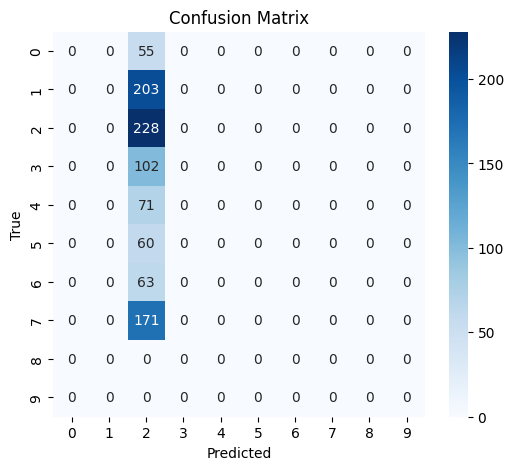

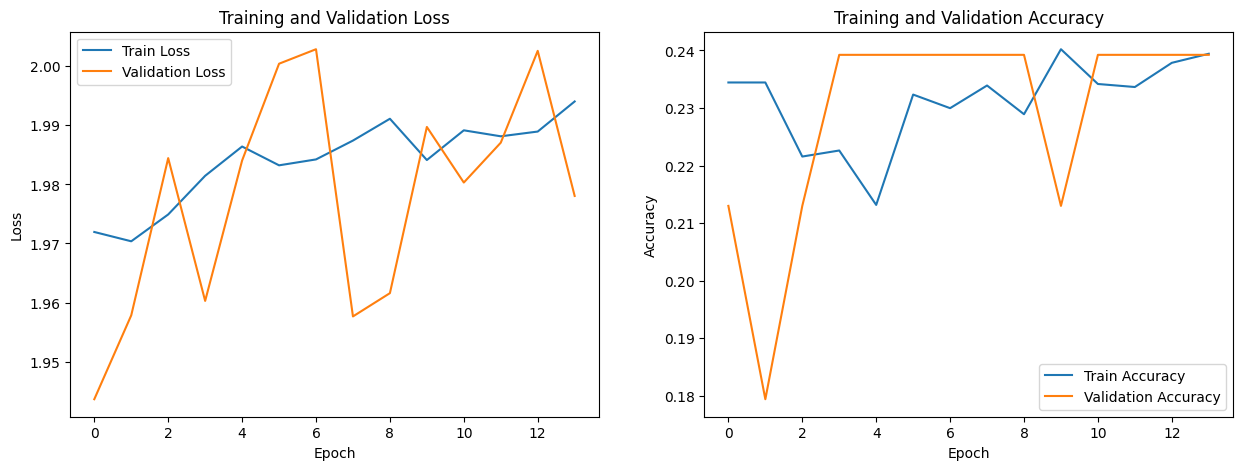

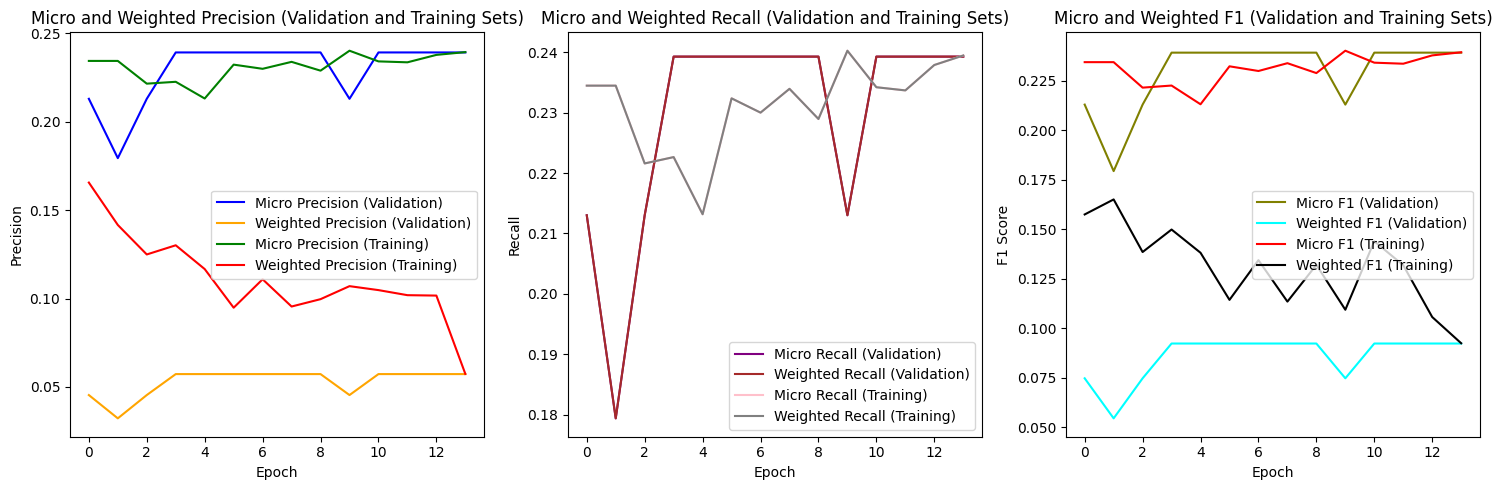

Training Progress: 100%|██████████| 50/50 [25:18<00:00, 30.36s/it, train_loss=1.5084, train_acc=0.6103964447975159, val_loss=1.9582, val_acc=0.48793283104896545] 


Mean Acc: 0.4111437538266182, Std Acc: 0.0860897899232197
Mean Weighted F1: 0.36166948288679124, Std Weighted F1: 0.12922666855420584
Mean Micro F1: 0.4111437538266182, Std Micro F1: 0.0860897899232197

Mean Weighted Precision: 0.3559826538711786, Std Weighted Precision: 0.14283643296562226
Mean Micro Precision: 0.4111437538266182, Std Micro Precision: 0.0860897899232197

Mean Weighted Recall: 0.41114375710487366, Std Weighted Recall: 0.08608979155414008
Mean Micro Recall: 0.4111437538266182, Std Micro Recall: 0.0860897899232197



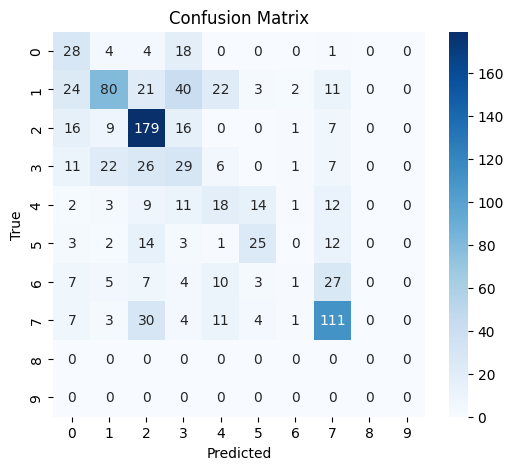

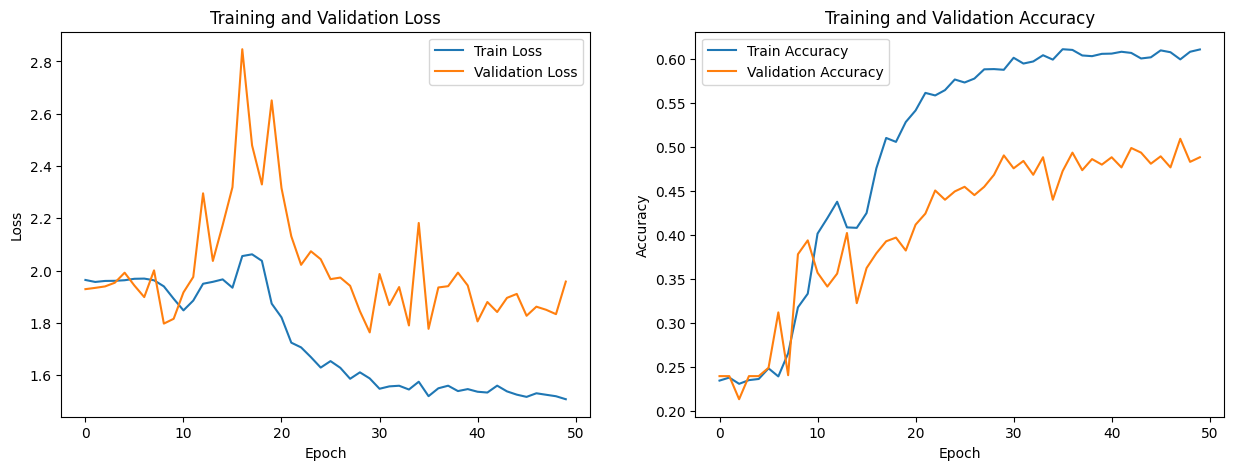

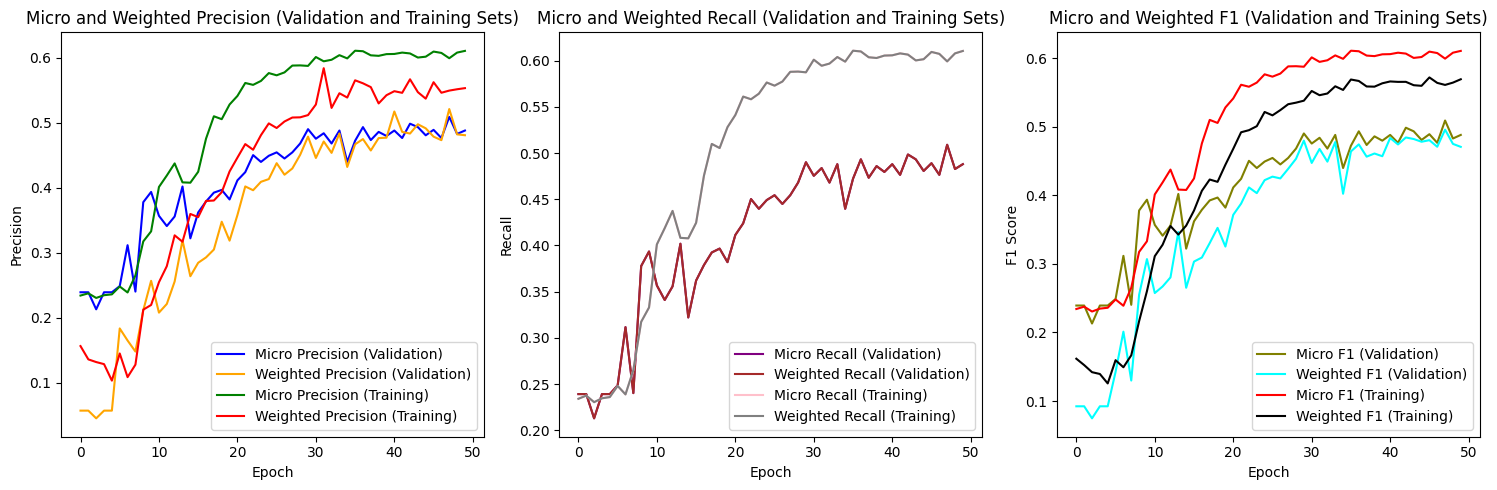

Training Progress:  20%|██        | 10/50 [05:56<23:46, 35.65s/it, train_loss=1.9642, train_acc=0.23910760879516602, val_loss=1.9441, val_acc=0.23949579894542694]



Early stopping after 10 epochs without improvement.
Mean Acc: 0.23453017662871967, Std Acc: 0.010533675638864882
Mean Weighted F1: 0.08922949568791823, Std Weighted F1: 0.007045801695750799
Mean Micro F1: 0.23453017662871967, Std Micro F1: 0.010533675638864882

Mean Weighted Precision: 0.05511535975066098, Std Weighted Precision: 0.004757857150688154
Mean Micro Precision: 0.23453017662871967, Std Micro Precision: 0.010533675638864882

Mean Weighted Recall: 0.23453017662871967, Std Weighted Recall: 0.010533675638864882
Mean Micro Recall: 0.23453017662871967, Std Micro Recall: 0.010533675638864882



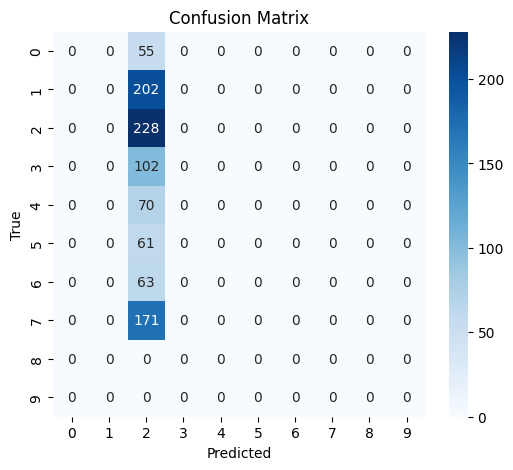

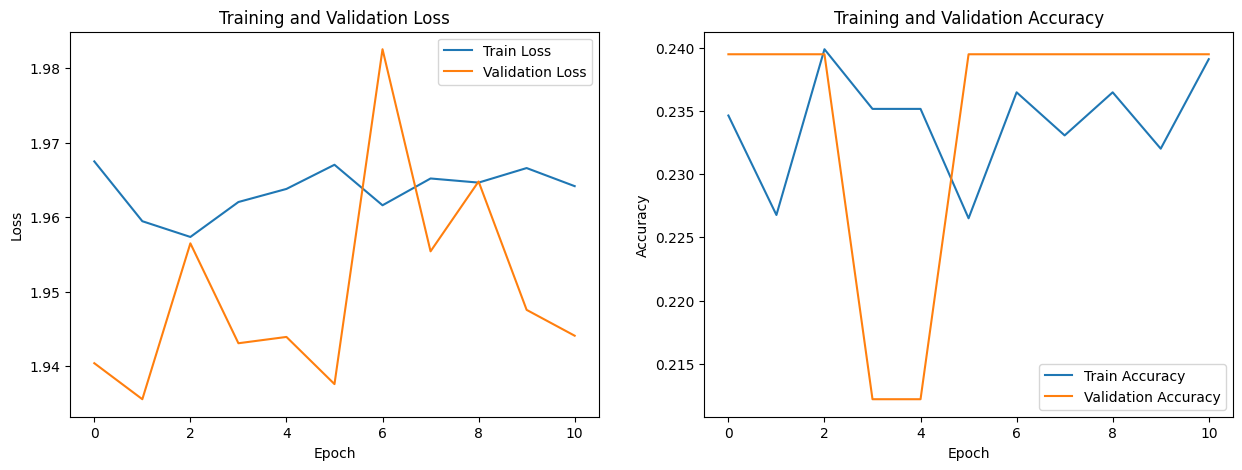

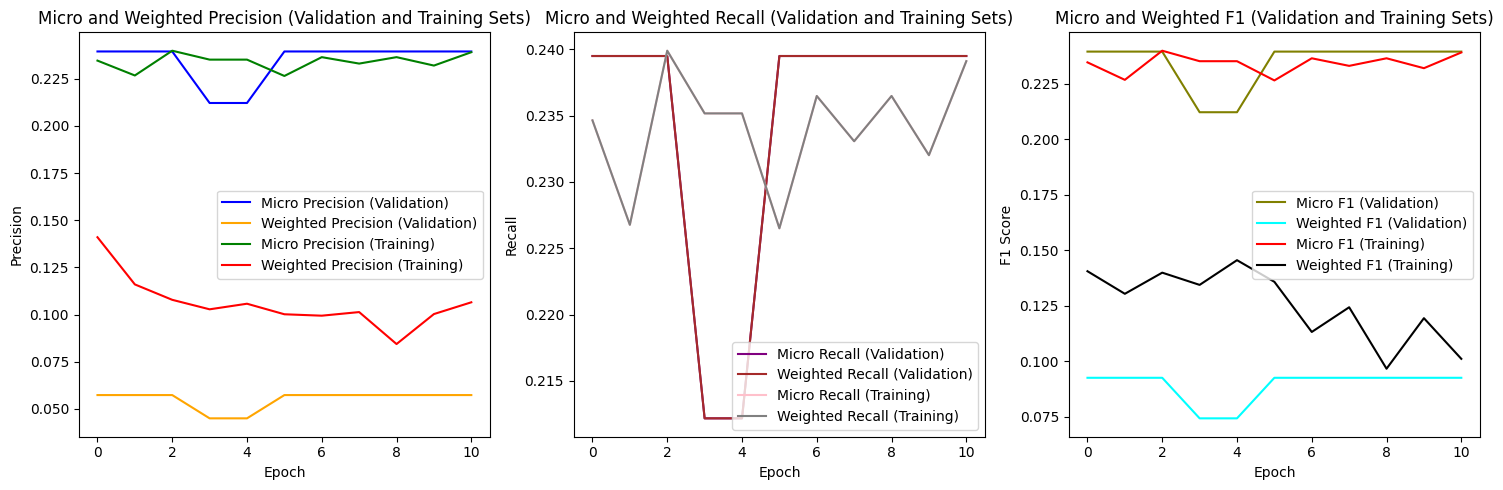

Training Progress:  20%|██        | 10/50 [05:57<23:51, 35.78s/it, train_loss=1.9747, train_acc=0.23858267068862915, val_loss=1.9825, val_acc=0.212184876203537]  



Early stopping after 10 epochs without improvement.
Mean Acc: 0.23204736547036606, Std Acc: 0.012163240931309686
Mean Weighted F1: 0.08756878430193121, Std Weighted F1: 0.00813579101139689
Mean Micro F1: 0.23204736547036606, Std Micro F1: 0.012163240931309686

Mean Weighted Precision: 0.05399392206560482, Std Weighted Precision: 0.005493900213431182
Mean Micro Precision: 0.23204736547036606, Std Micro Precision: 0.012163240931309686

Mean Weighted Recall: 0.23204736547036606, Std Weighted Recall: 0.012163240931309686
Mean Micro Recall: 0.23204736547036606, Std Micro Recall: 0.012163240931309686



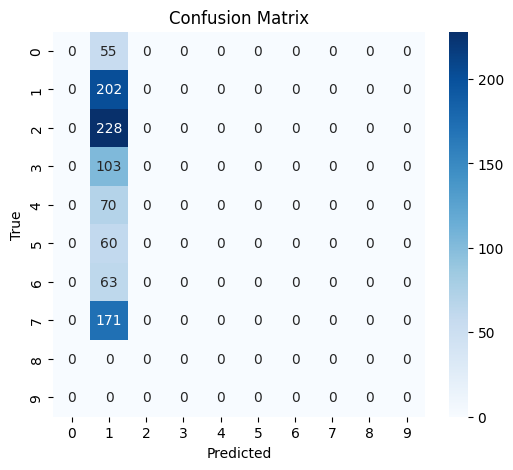

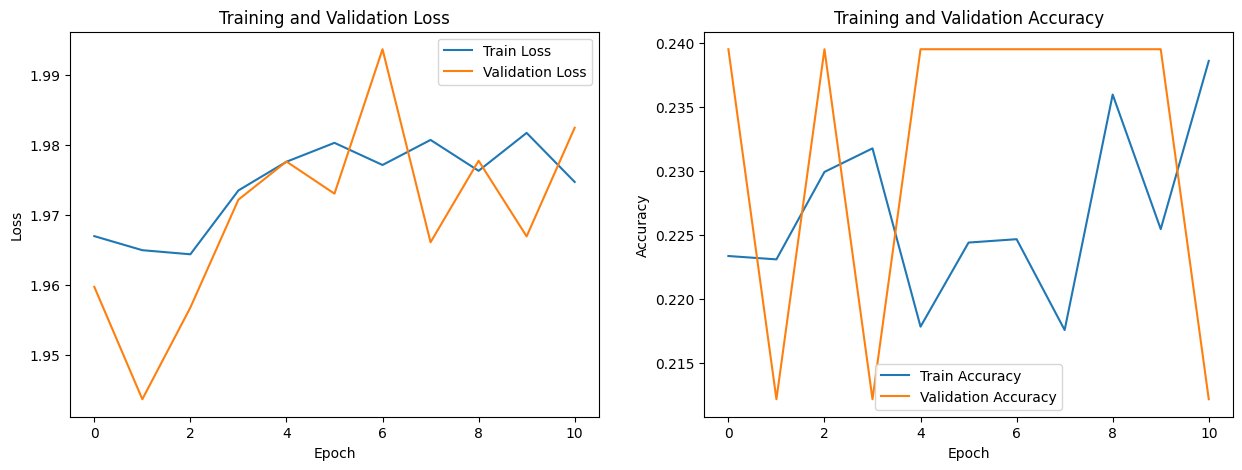

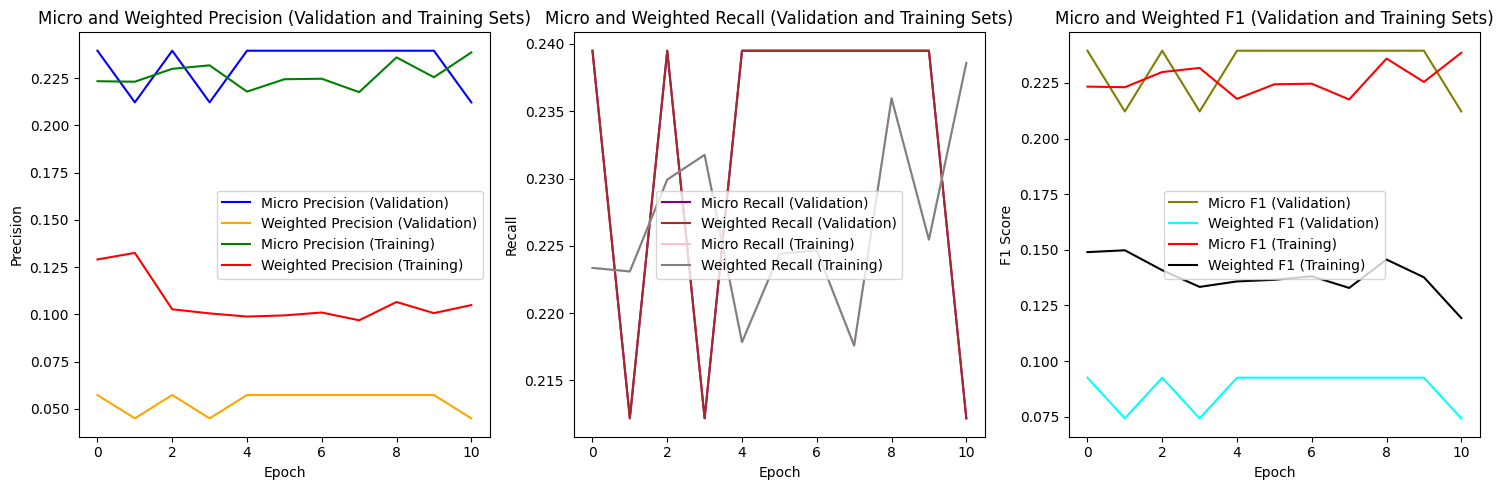

Training Progress:  58%|█████▊    | 29/50 [14:48<10:43, 30.62s/it, train_loss=0.9643, train_acc=0.8010498881340027, val_loss=1.5362, val_acc=0.654411792755127] 



Early stopping after 10 epochs without improvement.
Mean Acc: 0.6292717119057973, Std Acc: 0.07523137131627483
Mean Weighted F1: 0.6003141204516093, Std Weighted F1: 0.10623684904010579
Mean Micro F1: 0.6292717119057973, Std Micro F1: 0.07523137131627483

Mean Weighted Precision: 0.6037445217370987, Std Weighted Precision: 0.11591452267176368
Mean Micro Precision: 0.6292717119057973, Std Micro Precision: 0.07523137131627483

Mean Weighted Recall: 0.6292717138926188, Std Weighted Recall: 0.07523137092605178
Mean Micro Recall: 0.6292717119057973, Std Micro Recall: 0.07523137131627483



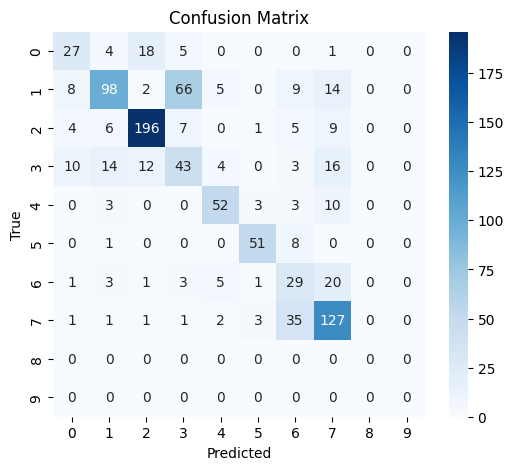

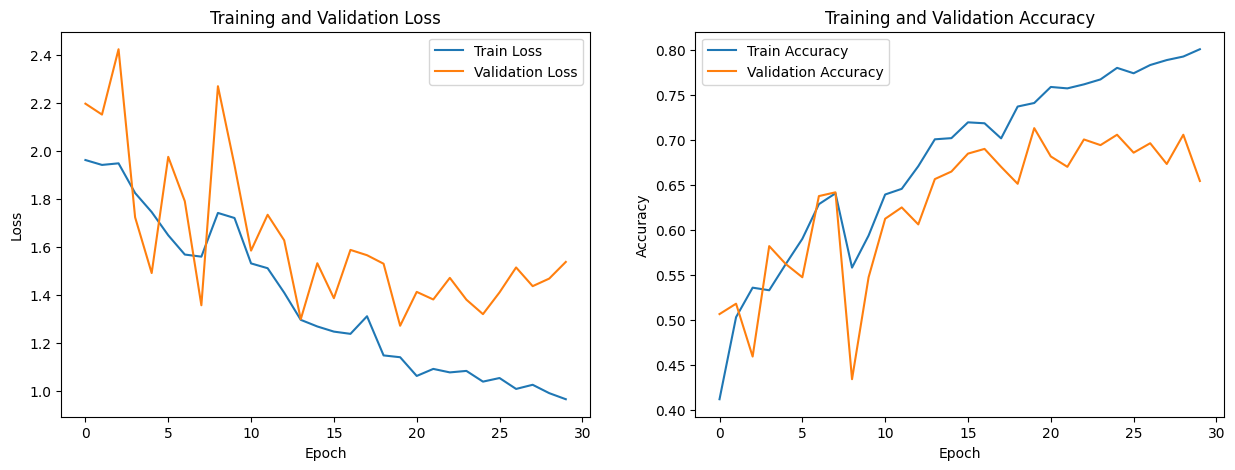

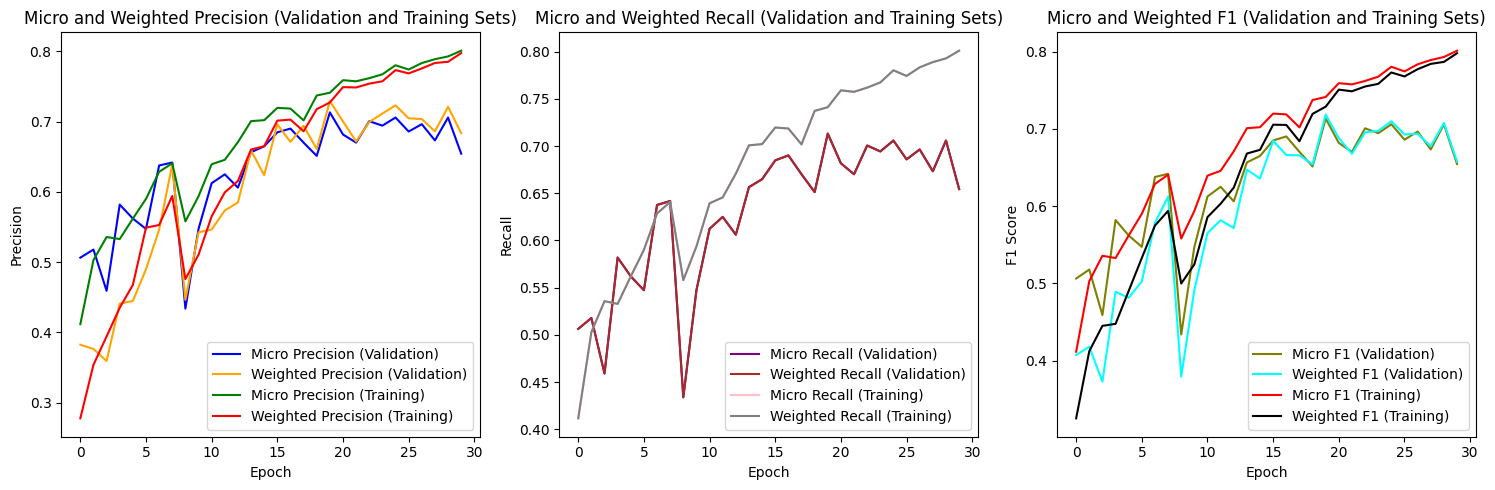

In [18]:
zarr_root = '/kaggle/input/timematchdata/data'
labels_path = '/kaggle/input/timematchdata/labels_fixed.json'
metadata_path = '/kaggle/input/timematchdata/metadata.pkl'

# 1. Preprocessing and counting of labels
pre = TimeMatchPreprocessor(zarr_root, labels_path, metadata_path)
pre_dataset, labels_str, acq_dates = pre.run()

all_labels = [plot[-1] for plot in pre_dataset]
unique_labels = np.unique(all_labels)

labels_dict = {k:v for k, v in zip(unique_labels, np.unique(labels_str))}
print(f"Index to label mapping:\n {labels_dict}")

pre_ims = [tup[1] for tup in pre_dataset]
pre_ls = [tup[2] for tup in pre_dataset]

# 3. 5-Fold Cross-Validation of the model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = np.arange(len(pre_dataset))
y = np.array([label for _,_,label in pre_dataset])

for train_idx, val_idx in skf.split(X, y):
    rs_dataset = PixelSamplerDataset(pre_ims, pre_ls, num_pixels=32)
    train_subset = torch.utils.data.Subset(rs_dataset, train_idx)
    val_subset = torch.utils.data.Subset(rs_dataset, val_idx)
    trainer = ModelsTrainer(
        model = FullPipelineModel(ts_dates=acq_dates, input_dim=10, hidden_dim=16, output_dim_1=32, 
                                  output_dim_2=128, d_model=128, num_classes=len(unique_labels)),
        train_loader=DataLoader(train_subset, batch_size=1, shuffle=True),
        val_loader=DataLoader(val_subset, batch_size=1, shuffle=False))
    
    trainer.train()
    trainer.plot_metrics()